# Entropia de Shannon


## Preparação do ambiente
Nesta seção importamos as bibliotecas necessárias e definimos utilitários básicos.


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter
import heapq
import random

np.set_printoptions(precision=6, suppress=True)
random.seed(42)
np.random.seed(42)

def _to_prob_array(p, normalize: bool = True):
    """Converte p (lista/array/dict) em vetor 1D de probabilidades.
    - Se a soma != 1 e normalize=True, normaliza automaticamente.
    - Lança erro se houver valores negativos ou soma inválida.
    """
    if isinstance(p, dict):
        arr = np.array(list(p.values()), dtype=float)
    else:
        arr = np.array(p, dtype=float)
    if arr.ndim != 1:
        raise ValueError("p deve ser 1D.")
    if np.any(arr < 0):
        raise ValueError("Probabilidades não podem ser negativas.")
    s = arr.sum()
    if not np.isfinite(s) or s <= 0:
        raise ValueError("Soma total inválida para probabilidades.")
    if not np.isclose(s, 1.0):
        if normalize:
            arr = arr / s
        else:
            raise ValueError(f"A soma é {s}, mas normalize=False.")
    return arr

def entropy(p, base: float = 2.0, normalize: bool = True) -> float:
    """Entropia de Shannon H(X) = -\sum p_i log_b p_i.
    - p: vetor/lista/dict de probabilidades.
    - base: 2 (bits), e (nats) ou 10 (hartleys).
    - ignore zeros em p (0 log 0 = 0).
    """
    arr = _to_prob_array(p, normalize=normalize)
    mask = arr > 0
    arr_nz = arr[mask]
    return float(-(arr_nz * (np.log(arr_nz) / np.log(base))).sum())

def entropy_from_counts(counts, base: float = 2.0) -> float:
    """Estimador plug-in (MLE) a partir de contagens inteiras."""
    counts = np.array(counts, dtype=float)
    if counts.ndim != 1 or np.any(counts < 0):
        raise ValueError("counts deve ser 1D e não-negativo.")
    n = counts.sum()
    if n <= 0:
        raise ValueError("A soma das contagens deve ser positiva.")
    p = counts / n
    return entropy(p, base=base, normalize=False)

def cross_entropy(p, q, base: float = 2.0, normalize: bool = True) -> float:
    """Entropia cruzada H(p, q) = -\sum p_i log_b q_i."""
    p_arr = _to_prob_array(p, normalize=normalize)
    q_arr = _to_prob_array(q, normalize=normalize)
    if p_arr.shape != q_arr.shape:
        raise ValueError("p e q devem ter o mesmo tamanho.")
    # Onde p_i > 0 requer q_i > 0
    if np.any((p_arr > 0) & (q_arr == 0)):
        return math.inf
    mask = p_arr > 0
    return float(-(p_arr[mask] * (np.log(q_arr[mask]) / np.log(base))).sum())

def kl_divergence(p, q, base: float = 2.0, normalize: bool = True) -> float:
    """D_{KL}(p || q) = \sum p_i log_b (p_i / q_i)."""
    p_arr = _to_prob_array(p, normalize=normalize)
    q_arr = _to_prob_array(q, normalize=normalize)
    if p_arr.shape != q_arr.shape:
        raise ValueError("p e q devem ter o mesmo tamanho.")
    if np.any((p_arr > 0) & (q_arr == 0)):
        return math.inf
    mask = p_arr > 0
    return float(((np.log(p_arr[mask]) - np.log(q_arr[mask])) / np.log(base) * p_arr[mask]).sum())

def perplexity(p, base: float = 2.0, normalize: bool = True) -> float:
    """Perplexidade = b^{H_b(p)}. Em bits (b=2), Perplexidade = 2^{H}."""
    return float(base ** entropy(p, base=base, normalize=normalize))

def miller_madow_correction(counts, base: float = 2.0) -> float:
    """Estimador de Miller–Madow (correção de viés, bits por padrão).
    H_MM = H_MLE + (k-1)/(2N ln base), onde k é nº de categorias observadas.
    """
    counts = np.array(counts, dtype=float)
    n = counts.sum()
    if n <= 0:
        raise ValueError("A soma das contagens deve ser positiva.")
    k = int((counts > 0).sum())
    H_mle = entropy_from_counts(counts, base=base)
    correction = (k - 1) / (2.0 * n * np.log(base))
    return float(H_mle + correction)

def huffman_code_lengths(probs):
    """Computa os comprimentos de código de Huffman (prefixo) para uma distribuição.
    Retorna uma lista 'lengths' onde lengths[i] é o comprimento do código do símbolo i.
    Implementação baseada em heap: a cada fusão, incrementa 1 no comprimento dos símbolos combinados.
    """
    probs = _to_prob_array(probs, normalize=True)
    n = len(probs)
    if n == 1:
        return [0]  # caso degenerado: nenhuma incerteza
    heap = [(float(p), [i]) for i, p in enumerate(probs)]
    heapq.heapify(heap)
    lengths = [0] * n
    while len(heap) > 1:
        p1, s1 = heapq.heappop(heap)
        p2, s2 = heapq.heappop(heap)
        for s in s1:
            lengths[s] += 1
        for s in s2:
            lengths[s] += 1
        heapq.heappush(heap, (p1 + p2, s1 + s2))
    return lengths

def expected_code_length(lengths, probs):
    probs = _to_prob_array(probs, normalize=True)
    lengths = np.array(lengths, dtype=float)
    if lengths.shape[0] != probs.shape[0]:
        raise ValueError("Dimensões incompatíveis.")
    return float((lengths * probs).sum())


## Definição formal e intuição

**Definição (Shannon, 1948):** A entropia de uma variável aleatória discreta $X$ com distribuição $p(x)$ é
$$
H_b(X) \;=\; - \sum_{x} p(x)\,\log_b p(x)
$$
onde $b$ é a base do logaritmo (tipicamente $b=2$ → **bits**; $b=e$ → **nats**; $b=10$ → **hartleys**).

**Intuição:** $H(X)$ mede a incerteza média sobre o resultado de $X$.  
- Se $X$ é determinística (uma categoria com probabilidade 1), então $H(X)=0$.  
- Para uma moeda justa $X \\in \{0,1\}$, $H(X)=1$ bit.  
- A entropia é **máxima** quando a distribuição é uniforme sobre $k$ resultados: $H(X)=\log_b k$.

**Propriedades úteis**  
- $H(X) \ge 0$.  
- $H(X)$ é **concava** em $p$.  
- **Regra da cadeia**: $H(X,Y) = H(X) + H(Y|X)$.  
- $H(X) \le \log_b k$ com igualdade iff $p$ é uniforme sobre $k$ suportes.


In [2]:
# Alguns cheques rápidos
print("H([0.5, 0.5]) = ", entropy([0.5, 0.5]))  # esperado ~1 bit
print("H([0.7, 0.2, 0.1]) = ", entropy([0.7, 0.2, 0.1]))

for k in [2, 4, 8]:
    uniform = np.ones(k)/k
    print(f"H(uniforme k={k}) = ", entropy(uniform), "; log2(k) = ", np.log2(k))


H([0.5, 0.5]) =  1.0
H([0.7, 0.2, 0.1]) =  1.1567796494470395
H(uniforme k=2) =  1.0 ; log2(k) =  1.0
H(uniforme k=4) =  2.0 ; log2(k) =  2.0
H(uniforme k=8) =  3.0 ; log2(k) =  3.0


## Curva de entropia da Bernoulli

Para uma moeda com $P(X=1)=p$, temos $H(X)= -p\log_2 p - (1-p)\log_2(1-p)$.
O máximo ocorre em $p=0{,}5$ (moeda justa). Abaixo, visualizamos essa curva.


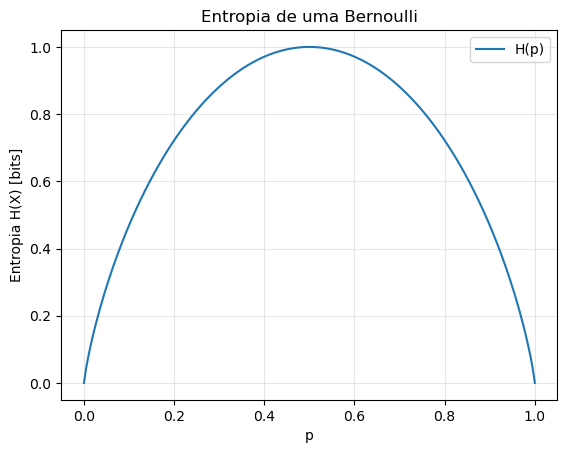

In [3]:
# Curva H(p) para Bernoulli
p = np.linspace(0.0, 1.0, 201)
# tratar termos 0 log 0 como 0
def h_binary(p):
    p = np.clip(p, 1e-15, 1 - 1e-15)
    return -(p*np.log2(p) + (1-p)*np.log2(1-p))

H = h_binary(p)

plt.figure()
plt.plot(p, H, label="H(p)")
plt.xlabel("p")
plt.ylabel("Entropia H(X) [bits]")
plt.title("Entropia de uma Bernoulli")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Distribuições k-árias: entropia máxima na uniforme
Para $k$ categorias equiprováveis, $H(X)=\log_2 k$. Visualizamos a tendência abaixo.


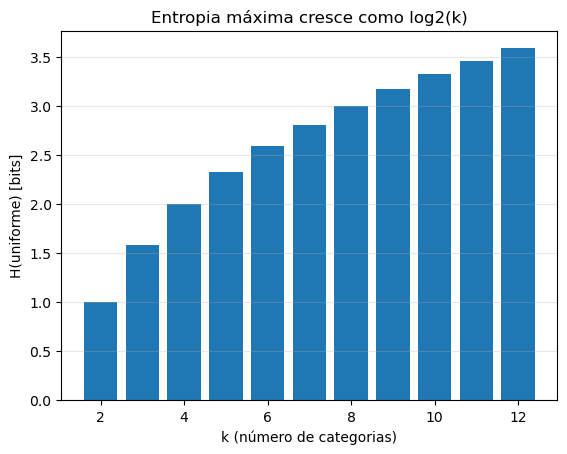

In [4]:
K = np.arange(2, 13)
H_uniform = np.log2(K)

plt.figure()
plt.bar(K, H_uniform)
plt.xlabel("k (número de categorias)")
plt.ylabel("H(uniforme) [bits]")
plt.title("Entropia máxima cresce como log2(k)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()


## Entropia conjunta e condicional (Regra da cadeia)

Seja $X \sim \text{Bernoulli}(p_x)$ e $Y = X \oplus N$ com ruído binário $N \sim \text{Bernoulli}(e)$ independente.
Então $H(Y|X) = h_2(e)$ (a entropia binária no parâmetro $e$), e a **regra da cadeia** dá:
$$
H(X,Y) = H(X) + H(Y|X).
$$

Abaixo verificamos numericamente essa igualdade construindo a distribuição conjunta.


In [5]:
def joint_xy(px=0.5, e=0.1):
    p = {
        (0,0): (1-px)*(1-e),
        (0,1): (1-px)*e,
        (1,0): px*e,
        (1,1): px*(1-e),
    }
    return p

def marginal_from_joint(joint, idx=0):
    counts = {}
    for (x,y), v in joint.items():
        key = x if idx==0 else y
        counts[key] = counts.get(key, 0.0) + v
    # ordenar por chave para consistência
    keys = sorted(counts.keys())
    return np.array([counts[k] for k in keys], dtype=float)

px, e = 0.37, 0.2
joint = joint_xy(px, e)
pX = marginal_from_joint(joint, idx=0)
pY = marginal_from_joint(joint, idx=1)

H_X = entropy(pX)
H_Y = entropy(pY)
H_XY = entropy(list(joint.values()))
H_Y_given_X = H_XY - H_X

print(f"H(X)      = {H_X:.6f} bits")
print(f"H(Y)      = {H_Y:.6f} bits")
print(f"H(X,Y)    = {H_XY:.6f} bits")
print(f"H(Y|X)    = {H_Y_given_X:.6f} bits")
print(f"H(X) + H(Y|X) = {H_X + H_Y_given_X:.6f} bits (deve igualar H(X,Y))")


H(X)      = 0.950672 bits
H(Y)      = 0.982373 bits
H(X,Y)    = 1.672600 bits
H(Y|X)    = 0.721928 bits
H(X) + H(Y|X) = 1.672600 bits (deve igualar H(X,Y))


## Entropia cruzada e divergência KL

- **Entropia cruzada**: $H(p, q) = - \sum_x p(x)\log_b q(x)$ mede o custo médio ao codificar amostras de $p$ com um código ótimo para $q$.
- **Divergência de Kullback–Leibler (KL)**: $D_{KL}(p\parallel q) = \sum_x p(x)\log_b \frac{p(x)}{q(x)} \ge 0$, com igualdade sse $p=q$.

Relação: $H(p, q) = H(p) + D_{KL}(p\parallel q)$.


In [6]:
p = np.array([0.5, 0.25, 0.25])
q_good = np.array([0.45, 0.3, 0.25])
q_bad  = np.array([0.7, 0.15, 0.15])

Hp   = entropy(p)
Hpq1 = cross_entropy(p, q_good)
Hpq2 = cross_entropy(p, q_bad)
DKL1 = kl_divergence(p, q_good)
DKL2 = kl_divergence(p, q_bad)

print("H(p)           =", Hp)
print("H(p,q_good)    =", Hpq1, " | D_KL(p||q_good) =", DKL1, " | H+DKL =", Hp + DKL1)
print("H(p,q_bad)     =", Hpq2, " | D_KL(p||q_bad)  =", DKL2, " | H+DKL =", Hp + DKL2)


H(p)           = 1.5
H(p,q_good)    = 1.5102429452640767  | D_KL(p||q_good) = 0.010242945264076611  | H+DKL = 1.5102429452640767
H(p,q_bad)     = 1.6257693834979823  | D_KL(p||q_bad)  = 0.12576938349798228  | H+DKL = 1.6257693834979823


## Compressão e códigos de Huffman

Shannon provou que o comprimento médio de qualquer código prefixo $L$ satisfaz $H \le L < H + 1$ (em bits).
O algoritmo de **Huffman** encontra, para uma distribuição fixa, um código prefixo ótimo que minimiza $L$.

A seguir comparamos $H$ e $L$ variando uma distribuição de 4 símbolos $p = [p, (1-p)/3, (1-p)/3, (1-p)/3]$.


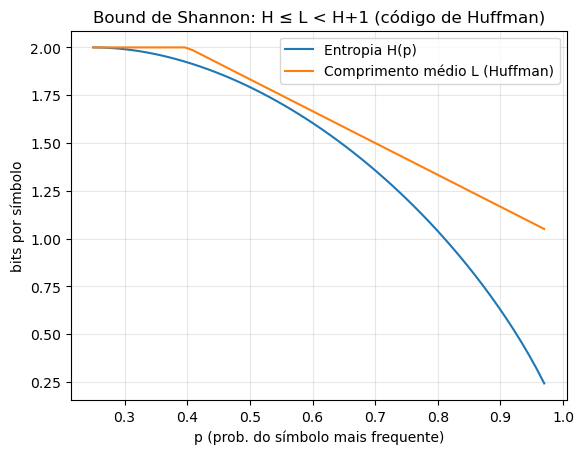

In [7]:
ps = np.linspace(0.25, 0.97, 60)  # a partir do uniforme (0.25)
H_vals = []
L_vals = []
for p1 in ps:
    probs = np.array([p1, (1-p1)/3, (1-p1)/3, (1-p1)/3])
    H_vals.append(entropy(probs))
    lengths = huffman_code_lengths(probs)
    L_vals.append(expected_code_length(lengths, probs))

H_vals = np.array(H_vals)
L_vals = np.array(L_vals)

plt.figure()
plt.plot(ps, H_vals, label="Entropia H(p)")
plt.plot(ps, L_vals, label="Comprimento médio L (Huffman)")
plt.xlabel("p (prob. do símbolo mais frequente)")
plt.ylabel("bits por símbolo")
plt.title("Bound de Shannon: H ≤ L < H+1 (código de Huffman)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Estimando entropia a partir de amostras

O estimador **plug-in (MLE)** substitui probabilidades por frequências relativas $\\hat p_i = n_i/N$.
Para amostras finitas, o MLE é tendencioso para baixo (subestima $H$). A correção de **Miller–Madow** adiciona

$(k-1)/(2N\\ln b)$ (em bits quando $b=2$).

Abaixo simulamos o viés em função do tamanho amostral.


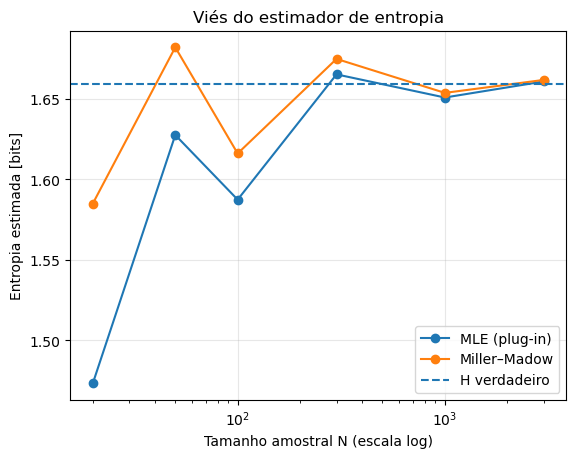

In [8]:
# Distribuição verdadeira (não uniforme)
p_true = np.array([0.6, 0.2, 0.1, 0.07, 0.03])
H_true = entropy(p_true)

def sample_counts(p, n):
    xs = np.random.choice(len(p), size=n, p=p)
    c = Counter(xs)
    counts = np.array([c.get(i, 0) for i in range(len(p))], dtype=int)
    return counts

Ns = [20, 50, 100, 300, 1000, 3000]
replicates = 50

means_mle = []
means_mm  = []

for N in Ns:
    est_mle = []
    est_mm  = []
    for _ in range(replicates):
        counts = sample_counts(p_true, N)
        est_mle.append(entropy_from_counts(counts))
        est_mm.append(miller_madow_correction(counts))
    means_mle.append(np.mean(est_mle))
    means_mm.append(np.mean(est_mm))

plt.figure()
plt.plot(Ns, means_mle, marker='o', label="MLE (plug-in)")
plt.plot(Ns, means_mm,  marker='o', label="Miller–Madow")
plt.axhline(H_true, linestyle='--', label="H verdadeiro")
plt.xscale('log')
plt.xlabel("Tamanho amostral N (escala log)")
plt.ylabel("Entropia estimada [bits]")
plt.title("Viés do estimador de entropia")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Perplexidade

A **perplexidade** é $b^{H_b(p)}$. Em bits ($b=2$), é o número efetivo de resultados equiprováveis.
Por exemplo, se $H=3$ bits, a perplexidade é $2^3=8$. Para linguagem natural, perplexidade aproxima a
“surpresa média” por token.


In [9]:
# Perplexidade para algumas distribuições
dists = {
    "Bernoulli(0.5)": [0.5, 0.5],
    "Quase determinística": [0.99, 0.01],
    "Uniforme(4)": [0.25, 0.25, 0.25, 0.25],
    "Skew(0.7,0.2,0.1)": [0.7, 0.2, 0.1],
}

for name, p in dists.items():
    H = entropy(p)
    PP = perplexity(p)
    print(f"{name:>20s}  |  H = {H:6.4f} bits  |  Perplexidade ≈ {PP:6.3f}")


      Bernoulli(0.5)  |  H = 1.0000 bits  |  Perplexidade ≈  2.000
Quase determinística  |  H = 0.0808 bits  |  Perplexidade ≈  1.058
         Uniforme(4)  |  H = 2.0000 bits  |  Perplexidade ≈  4.000
   Skew(0.7,0.2,0.1)  |  H = 1.1568 bits  |  Perplexidade ≈  2.230
